In [2]:
# Step 0. Load libraries and custom modules
# Basic input/output ---------------------------------------------------
import pickle
import urllib
import tarfile
# Matrices and dataframes ----------------------------------------------
import numpy as np
import pandas as pd
# Visualizations -------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Data pre-processing --------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
# Clustering -----------------------------------------------------------
from sklearn.cluster import KMeans
# Metrics --------------------------------------------------------------
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [2]:
# Step 1. Load data and prepare
# Information: These data contain gene expression values from a 
# manuscript authored by The Cancer Genome Atlas (TCGA) Pan-Cancer 
# analysis project investigators.
# There are 881 samples (rows) representing five distinct cancer 
# subtypes. Each sample has gene expression values for 
# 20,531 genes (columns). The dataset is available from the 
# UC Irvine Machine Learning Repository

# The labels are strings containing abbreviations of cancer types:
# BRCA: Breast invasive carcinoma
# COAD: Colon adenocarcinoma
# KIRC: Kidney renal clear cell carcinoma
# LUAD: Lung adenocarcinoma
# PRAD: Prostate adenocarcinoma

# 1.1 Manual download (About 200MB)
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
# archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
# # Build the url
# full_download_url = urllib.parse.urljoin(url, archive_name)

# # Download the file
# r = urllib.request.urlretrieve (full_download_url, archive_name)

# # Extract the data from the archive
# tar = tarfile.open(archive_name, "r:gz")
# tar.extractall()
# tar.close()
# 1.2 Assume you have this on a data folder
df_raw_data = pd.read_csv('../Data/Raw/TCGA_data.csv')
df_raw_labels = pd.read_csv('../Data/Raw/TCGA_labels.csv')

In [3]:
# 1.2 Let's get the basic info
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [4]:
# 1.3 Let's see a sample of the data
df_raw_data.sample(10)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
560,sample_560,0.0,4.171767,2.599746,6.437777,10.420234,0.0,7.508547,0.000000,0.0,...,5.778390,8.486932,10.120484,7.126116,9.235033,10.768126,9.450723,9.592833,5.379760,0.0
574,sample_574,0.0,4.388382,3.528571,6.962989,9.731032,0.0,6.632124,0.370834,0.0,...,4.921746,8.094310,9.518592,7.968275,9.409654,11.747085,9.959708,10.234554,3.334311,0.0
549,sample_549,0.0,4.403799,5.650767,6.237965,9.928791,0.0,8.193653,0.729357,0.0,...,7.771054,9.087707,10.251198,2.791001,9.827970,11.474755,9.415547,9.388187,1.860605,0.0
500,sample_500,0.0,2.924765,2.654183,6.663558,9.341895,0.0,8.005950,0.000000,0.0,...,6.620494,9.458999,10.123229,6.212562,10.157713,11.421118,10.844808,10.216006,5.654857,0.0
331,sample_331,0.0,2.059113,2.506094,7.402500,10.958705,0.0,6.093165,0.356482,0.0,...,5.005041,8.712427,10.234291,8.594985,9.957193,12.400967,9.745041,10.490169,3.934960,0.0
221,sample_221,0.0,3.353521,4.464903,6.726954,9.231312,0.0,8.925738,0.899872,0.0,...,5.155191,8.123811,9.938328,5.510696,9.963569,12.695074,9.577087,9.692546,4.657869,0.0
300,sample_300,0.0,2.968773,3.078490,6.566817,9.115577,0.0,9.709370,1.238542,0.0,...,6.086642,8.337934,10.423683,7.805022,8.950941,11.859729,10.620916,9.736067,8.253682,0.0
744,sample_744,0.0,0.540821,1.687240,7.077980,10.053288,0.0,9.459534,0.618239,0.0,...,5.739700,9.007431,9.722410,6.353886,9.576371,12.661273,9.730609,9.242224,7.914295,0.0
467,sample_467,0.0,3.144503,1.053667,6.893386,10.498221,0.0,8.181391,0.000000,0.0,...,4.906193,7.635769,9.747215,6.085119,9.461506,12.117328,9.241354,9.113622,4.823408,0.0
749,sample_749,0.0,3.576764,3.645598,6.623074,10.169587,0.0,6.504433,0.000000,0.0,...,6.588062,9.058747,10.039467,5.234107,9.390846,10.480104,10.538839,8.975415,4.042706,0.0


In [5]:
# 1.4 Now let's see the labels info
df_raw_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [6]:
# 1.5 Show a sample of the labels
df_raw_labels.sample(6)

,Unnamed: 0,Class
699,sample_699,KIRC
446,sample_446,KIRC
619,sample_619,BRCA
441,sample_441,BRCA
537,sample_537,PRAD
770,sample_770,BRCA


In [7]:
# Step 2. Transform data 
# 2.1 Drop unused columns
df_interim_data = df_raw_data.drop(df_raw_data.columns[0], axis=1)
df_interim_labels = df_raw_labels.drop(df_raw_labels.columns[0], axis=1)
# 2.2 Concatenate dataframes
df_interim = pd.concat([df_interim_data, df_interim_labels], axis=1)

In [8]:
# Step 3. Perform EDA
# 3.1 Describe the data
df_interim.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [9]:
# Step 4. Cluster the data
# 4.1 Separate the data
X = df_interim.drop(['Class'], axis=1)
y = df_interim[['Class']]
no_clusters = y['Class'].nunique()

# 4.2 Create a preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', MinMaxScaler()),
    ('PCA', PCA(n_components=2, random_state=123))
])

# 4.3 Create a clusterer pipeline
clusterer = Pipeline([
    ('kmeans', KMeans(n_clusters=no_clusters, 
                      init='k-means++', 
                      random_state=123))
])

# 4.4 Join the preprocessing and clusterer into a pipe
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', clusterer)
])

# 4.5 Fit the data into the pipe
pipe.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('PCA',
                                  PCA(n_components=2, random_state=123))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=5, random_state=123))]))])

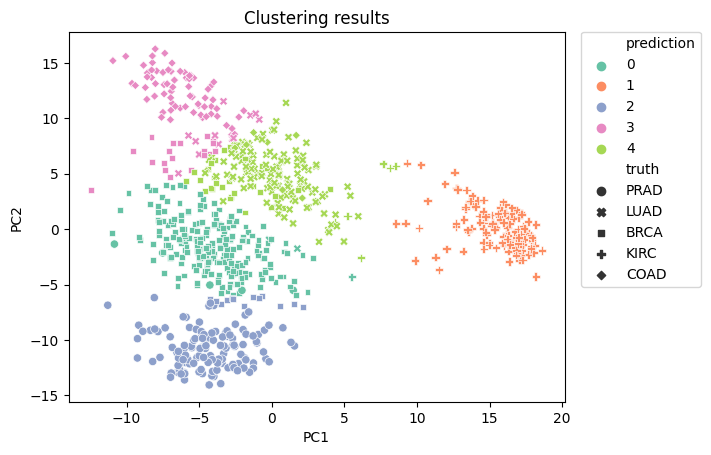

In [10]:
# 4.6 Create a dataframe placeholder
df = pd.DataFrame(pipe['preprocessor'].transform(X), 
                  columns=['PC1','PC2'])
df['prediction'] = pipe['clusterer']['kmeans'].labels_
df['truth'] = y

# 4.7 Compare the results using a plot
plot = sns.scatterplot(x='PC1', 
                       y='PC2', 
                       data=df, 
                       hue='prediction', 
                       style='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.show()

In [11]:
# 4.8 Calculate Silhouette Score
preproc_data = pipe['preprocessor'].transform(X)
s_score = silhouette_score(preproc_data, df['prediction'])
print(f'The silhouette score is {s_score:.3f}')

The silhouette score is 0.512


In [16]:
# 5. Visualize using TSNE
X_tsne = TSNE(n_components=2, init='random',learning_rate=200.0).fit_transform(X)

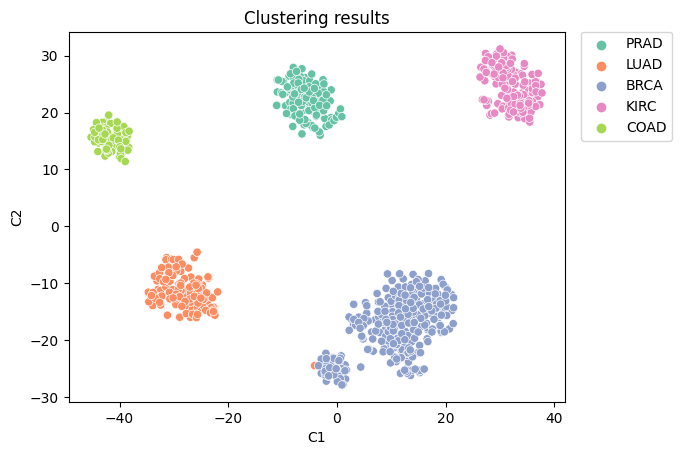

In [13]:
df_tsne = pd.DataFrame(X_tsne, columns=['C1','C2'])
df_tsne['truth'] = y
plot = sns.scatterplot(x='C1', 
                       y='C2', 
                       data=df_tsne,
                       hue='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.show()

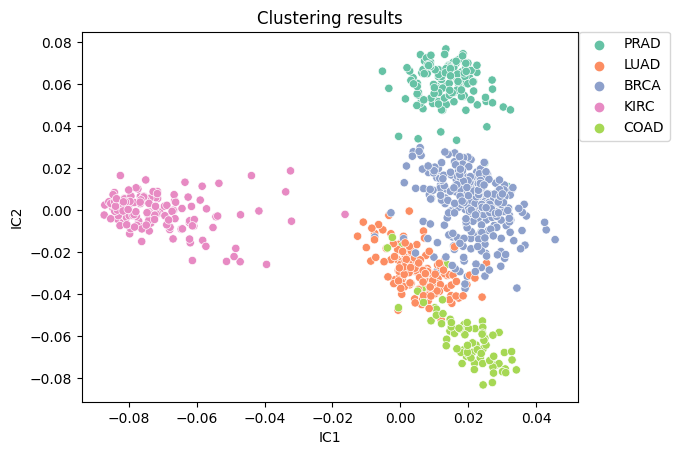

In [14]:
X_fica = FastICA(n_components=2).fit_transform(X)
df_fica = pd.DataFrame(X_fica, columns=['IC1','IC2'])
df_fica['truth'] = y
plot = sns.scatterplot(x='IC1', 
                       y='IC2', 
                       data=df_fica,
                       hue='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.2,1.02))
plt.show()

In [15]:
# Bibliography
# https://realpython.com/k-means-clustering-python/